# 43

In [1]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 및 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805)

[Bert Review](https://ffighting.net/deep-learning-paper-review/language-model/bert/)

# 44

In [2]:
import torch

# 감성 레이블을 숫자로 매칭하는 딕셔너리 준비
dic = {0:'positive', 1:'neutral', 2:'negative'}

# 입력 문장 데이터
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 정답 레이블(answer label)
ans = torch.tensor([0, 0, 1, 2, 2, 0])

# 45

In [3]:
# 파인 튜닝 없는 상태에서의 추론
# 모델을 eval 모드로 전환
model.eval()

# 그래디언트(기울기) 계산 방지. eval 모드에서는 학습이 이뤄지지 않기에 이 조치가 필요
with torch.no_grad():
  for article in eval_list:

    # eval_list에 담긴 문장을 article이라는 변수에 하나씩 담아 토크나이저 인코딩
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)

    # 인코딩 결과를 모델에 투입
    outputs = model(inputs)

    # 로짓 추출
    logits = outputs.logits

    # 로짓의 최대값에 해당하는 인덱스를 추출하고, item( )을 통해 파이썬 숫자 형태로 변환
    # 결과적으로 위 숫자가 변수 dic에 담긴 인덱스가 되어 해당하는 문장의 감성을 출력
    print(f"{dic[logits.argmax(-1).item()]}:{article}")

positive:I like apple
positive:I like pear
positive:I go to school
positive:I dislike mosquito
positive:I felt very sad
positive:I feel so good


#46

In [4]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=1e-5)

# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 50
losses = []

# 파인튜닝
for epoch in range(epochs):

    # 그래디언트(기울기) 초기화
    optimizer.zero_grad()

    # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
    inputs = tokenizer.batch_encode_plus(eval_list, return_tensors="pt", padding=True, truncation=True)

    # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
    # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
    outputs = model(**inputs, labels=ans)

    # 로짓 추출
    logits = outputs.logits

    # 손실 추출
    loss = outputs.loss

    # 오차역전파
    loss.backward()

    # 가중치(weight) 업데이트
    optimizer.step()

    # 손실을 빈 컨테이너 losses에 순서대로 저장
    losses.append(loss)

    # 에포크 및 손실 값 출력
    # 에포크는 0부터 시작하기에, 1을 더해줘서 사람들이 에포크 회수를 더 자연스럽게 인지하게 조치
    print(f"epoch:{epoch+1}, loss:{loss}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch:1, loss:1.0172853469848633
epoch:2, loss:1.0965728759765625
epoch:3, loss:1.0418553352355957
epoch:4, loss:1.073961853981018
epoch:5, loss:0.9522694945335388
epoch:6, loss:0.980685293674469
epoch:7, loss:0.8590216040611267
epoch:8, loss:0.8369211554527283
epoch:9, loss:0.9898821711540222
epoch:10, loss:0.8716272711753845
epoch:11, loss:0.8090453743934631
epoch:12, loss:0.8657459616661072
epoch:13, loss:0.9176375269889832
epoch:14, loss:0.7541628479957581
epoch:15, loss:0.7702352404594421
epoch:16, loss:0.7521576881408691
epoch:17, loss:0.7335765957832336
epoch:18, loss:0.7169167995452881
epoch:19, loss:0.7267470359802246
epoch:20, loss:0.7422470450401306
epoch:21, loss:0.6226918697357178
epoch:22, loss:0.5952328443527222
epoch:23, loss:0.6246941089630127
epoch:24, loss:0.6171831488609314
epoch:25, loss:0.5683595538139343
epoch:26, loss:0.5668479800224304
epoch:27, loss:0.5202606320381165
epoch:28, loss:0.5476173758506775
epoch:29, loss:0.525060772895813
epoch:30, loss:0.429247885

# 47

In [5]:
# 파이토치에서 item( )은 GPU로부터 값을 추출하여 CPU로 전달
new_losses = [i.item() for i in losses]

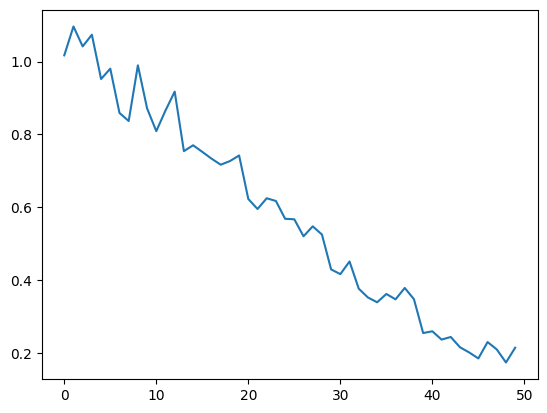

In [6]:
import matplotlib.pyplot as plt
plt.plot(new_losses);

# 48

In [7]:
# 파인 튜닝 이후 추론
dic = {0:'positive', 1:'neutral', 2:'negative'}
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for article in eval_list:
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{article}")


positive:I like apple
positive:I like pear
neutral:I go to school
negative:I dislike mosquito
negative:I felt very sad
positive:I feel so good


#49

In [8]:
# item()에 의해 넘파이 숫자값이 된 preds를 다시 토치 텐서 타입으로 변환
import torch
preds = torch.tensor(preds)

In [9]:
# preds 출력
preds

tensor([0, 0, 1, 2, 2, 0])

In [10]:
# 정답(ans)와 예측(preds)가 일치하는 건수를
# 정답(ans)의 전체 건수로 나누어서 정확도(Accuracy) 계산
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy:100.0%
